In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm

import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 25    
mpl.rcParams['ytick.labelsize'] = 25
# mpl.rcParams['font.size'] = 28
mpl.rcParams['font.size'] = 35
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

In [2]:
base_path = '/beegfs/desy/user/akorol'

In [3]:
path = f'{base_path}/projects/getting_high/ILDConfig/StandardConfig/production/out/90GeV_all_steps.hdf5'
all_steps = h5py.File(path, 'r')['events'][:]

In [4]:
all_steps[:, 2, :] = all_steps[:, 2, :] + 40
all_steps[:, 0, :] = all_steps[:, 0, :] + 25

100%|██████████| 30/30 [00:00<00:00, 167.58it/s]


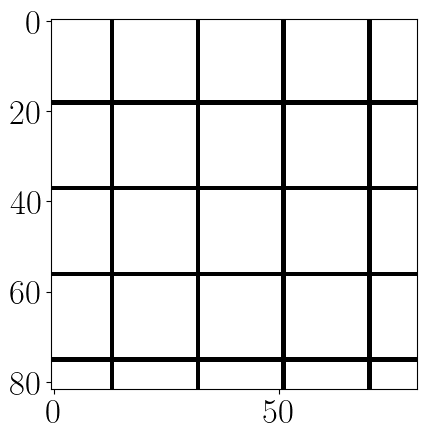

In [5]:
Ymin = 1811
Xmin = -200
Xmax = 200
Zmin = -160
Zmax = 240

half_cell_size = 5.0883331298828125/2
cell_thickness = 0.5250244140625
cell_size = 5.0883331298828125

dm = 1
offset = half_cell_size*2/(dm)

layer_bottom_pos = np.array([   1811.34020996, 1814.46508789, 1823.81005859, 1826.93505859,
                                    1836.2800293 , 1839.4050293 , 1848.75      , 1851.875     ,
                                    1861.2199707 , 1864.3449707 , 1873.68994141, 1876.81494141,
                                    1886.16003418, 1889.28503418, 1898.63000488, 1901.75500488,
                                    1911.09997559, 1914.22497559, 1923.56994629, 1926.69494629,
                                    1938.14001465, 1943.36499023, 1954.81005859, 1960.03503418,
                                    1971.47998047, 1976.70495605, 1988.15002441, 1993.375     ,
                                    2004.81994629, 2010.04504395])

X = np.load('/beegfs/desy/user/akorol/data/calo-clouds/muon-map/X.npy')
Z = np.load('/beegfs/desy/user/akorol/data/calo-clouds/muon-map/Z.npy')
Y = np.load('/beegfs/desy/user/akorol/data/calo-clouds/muon-map/Y.npy')
E = np.load('/beegfs/desy/user/akorol/data/calo-clouds/muon-map/E.npy')

inbox_idx = np.where((Y > Ymin) & (X < Xmax) & (X > Xmin) & (Z < Zmax) & (Z > Zmin) )[0]


X = X[inbox_idx]
Z = Z[inbox_idx]
Y = Y[inbox_idx]
E = E[inbox_idx]


def create_map(X, Y, Z, dm=1):
    """
        X, Y, Z: np.array 
            ILD coordinates of sencors hited with muons
        dm: int (1, 2, 3, 4, 5) dimension split multiplicity
    """

    offset = half_cell_size*2/(dm)

    layers = []
    H_base = []
    for l in tqdm(range(len(layer_bottom_pos))): # loop over layers
        idx = np.where((Y <= (layer_bottom_pos[l] + cell_thickness*1.5)) & (Y >= layer_bottom_pos[l] - cell_thickness/2 ))
        
        xedges = np.array([])
        zedges = np.array([])
        
        unique_X = np.unique(X[idx])
        unique_Z = np.unique(Z[idx])
        
        xedges = np.append(xedges, unique_X[0] - half_cell_size)
        xedges = np.append(xedges, unique_X[0] + half_cell_size)
        
        for i in range(len(unique_X)-1): # loop over X coordinate cell centers
            if abs(unique_X[i] - unique_X[i+1]) > half_cell_size * 1.9:
                xedges = np.append(xedges, unique_X[i+1] - half_cell_size)
                xedges = np.append(xedges, unique_X[i+1] + half_cell_size)
                
                for of_m in range(dm):
                    xedges = np.append(xedges, unique_X[i+1] - half_cell_size + offset*of_m) # for higher granularity
                
        for z in unique_Z: # loop over Z coordinate cell centers
            zedges = np.append(zedges, z - half_cell_size)
            zedges = np.append(zedges, z + half_cell_size)
            
            for of_m in range(dm):
                zedges = np.append(zedges, z - half_cell_size + offset*of_m) # for higher granularity
                
            
        zedges = np.unique(zedges)
        xedges = np.unique(xedges)
        
        xedges = [xedges[i] for i in range(len(xedges)-1) if abs(xedges[i] - xedges[i+1]) > 1e-3] + [xedges[-1]]
        zedges = [zedges[i] for i in range(len(zedges)-1) if abs(zedges[i] - zedges[i+1]) > 1e-3] + [zedges[-1]]
        
            
        H, xedges, zedges = np.histogram2d(X[idx], Z[idx], bins=(xedges, zedges))
        layers.append({'xedges': xedges, 'zedges': zedges, 'greed': H})

    return layers, offset


MAP, offset = create_map(X, Y, Z, dm=1)

plt.imshow(MAP[0]['greed'], cmap='gray')
plt.show()

In [6]:
# layers = []
for l in tqdm(range(len(layer_bottom_pos))):
    idx = np.where((Y <= (layer_bottom_pos[l] + 1)) & (Y >= layer_bottom_pos[l] ))
    
    xedges = np.array([])
    zedges = np.array([])
    
    unique_X = np.unique(X[idx])
    unique_Z = np.unique(Z[idx])
    
    xedges = np.append(xedges, unique_X[0] - half_cell_size)
    xedges = np.append(xedges, unique_X[0] + half_cell_size)
    
    for i in range(len(unique_X)-1):
        if abs(unique_X[i] - unique_X[i+1]) > half_cell_size * 1.9:
            xedges = np.append(xedges, unique_X[i+1] - half_cell_size)
            xedges = np.append(xedges, unique_X[i+1] + half_cell_size)
            
            for of_m in range(dm):
                xedges = np.append(xedges, unique_X[i+1] - half_cell_size + offset*of_m) # for higher granularity
            
    for z in unique_Z:
        zedges = np.append(zedges, z - half_cell_size)
        zedges = np.append(zedges, z + half_cell_size)
        
        for of_m in range(dm):
            zedges = np.append(zedges, z - half_cell_size + offset*of_m) # for higher granularity
        
    zedges = np.unique(zedges)
    xedges = np.unique(xedges)
    
    xedges = [xedges[i] for i in range(len(xedges)-1) if abs(xedges[i] - xedges[i+1]) > 1e-3] + [xedges[-1]]
    zedges = [zedges[i] for i in range(len(zedges)-1) if abs(zedges[i] - zedges[i+1]) > 1e-3] + [zedges[-1]]
    
        
    H, xedges, zedges = np.histogram2d(X[idx], Z[idx], bins=(xedges, zedges), weights=None)

    
    if l == 20:
        break

 67%|██████▋   | 20/30 [00:00<00:00, 157.83it/s]


In [7]:
zedges = np.unique(zedges)
xedges = np.unique(xedges)

In [8]:
n = 10

In [9]:
x = all_steps[n, 0][(all_steps[n, 1] > layer_bottom_pos[l]) & (all_steps[n, 1] < layer_bottom_pos[l] + cell_thickness)]
z = all_steps[n, 2][(all_steps[n, 1] > layer_bottom_pos[l]) & (all_steps[n, 1] < layer_bottom_pos[l] + cell_thickness)]
e = all_steps[n, 3][(all_steps[n, 1] > layer_bottom_pos[l]) & (all_steps[n, 1] < layer_bottom_pos[l] + cell_thickness)]


In [10]:
H_base, xedges_base, zedges_base = np.histogram2d(X[idx], Z[idx], bins=(xedges, zedges), weights=None)
X_mash_base, Z_mash_base = np.meshgrid(xedges, zedges)
H, xedges, zedges = np.histogram2d(x, z, bins=(xedges, zedges), weights=e)

In [11]:
xedges_high = np.arange(-100, 100, cell_size/6)
zedges_high = np.arange(-60, 140, cell_size/6)


H_high, xedges_high, zedges_high = np.histogram2d(x, z, bins=(xedges_high, zedges_high), weights=e)

In [12]:
H_base[H_base == 0] = -1
H_base[H_base > 0] = 0
H_base[H_base < 0] = 10

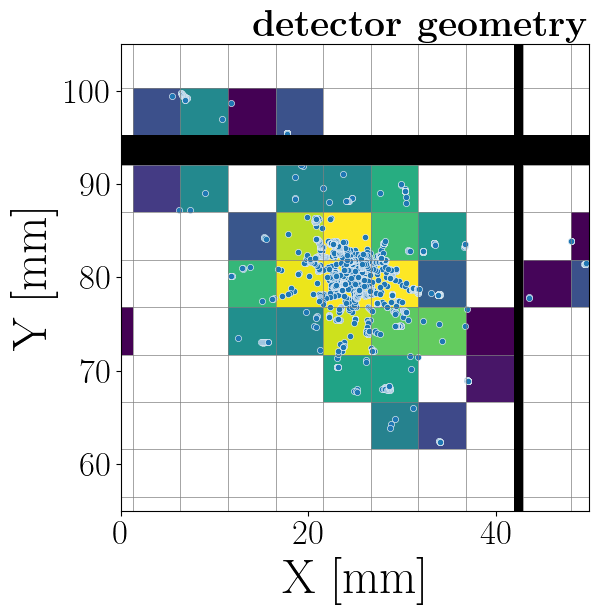

In [13]:
plt.figure(figsize=(7, 7))
X_mash, Z_mash = np.meshgrid(xedges, zedges)
# plt.pcolormesh(X_mash, Z_mash, np.log(H.T), cmap='gray')
# plt.pcolormesh(X_mash, Z_mash, H.T, cmap='viridis')
plt.pcolormesh(X_mash, Z_mash, np.log(H.T), cmap='viridis', vmax=-5, vmin=-9)


plt.scatter(x, z, s=20, color='tab:blue', edgecolors='white', lw=0.4)
for x_pos in xedges:
    plt.axvline(x_pos, color='gray', lw=0.5, zorder=1)
for z_pos in zedges:
    plt.axhline(z_pos, color='gray', lw=0.5, zorder=1)
plt.pcolormesh(X_mash_base, Z_mash_base, np.log(H_base.T), cmap='gray')
plt.ylabel('Y [mm]')
plt.xlabel('X [mm]')
plt.title(r'\textbf{detector geometry}', loc='right', fontsize=27)
plt.ylim(80-25, 80+25)
plt.xlim(0, 50)
plt.tight_layout()
plt.savefig('grid_base.png', dpi=300)
plt.show()

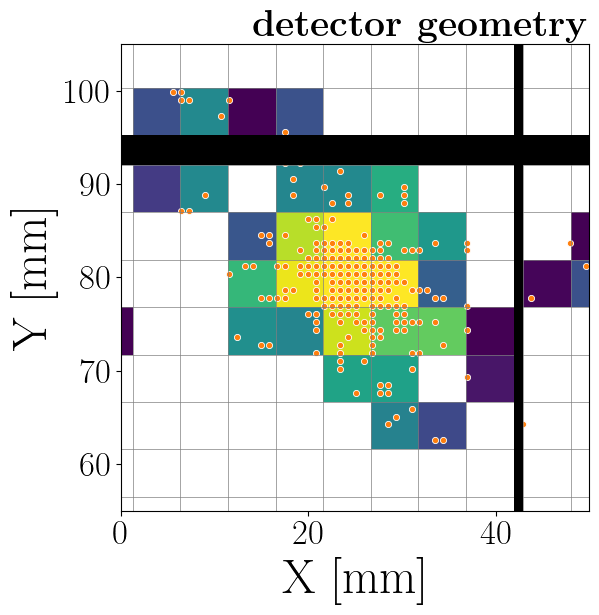

In [14]:
plt.figure(figsize=(7, 7))
X_mash, Z_mash = np.meshgrid(xedges, zedges)
# plt.pcolormesh(X_mash, Z_mash, np.log(H.T), cmap='gray')
# plt.pcolormesh(X_mash, Z_mash, H.T, cmap='viridis')
plt.pcolormesh(X_mash, Z_mash, np.log(H.T), cmap='viridis', vmax=-5, vmin=-9)


plt.scatter(xedges_high[np.where(H_high>0)[0]] + half_cell_size/6, zedges_high[np.where(H_high>0)[1]] + half_cell_size/6, color='tab:orange', edgecolors='white', s=20, lw=0.6)
for x_pos in xedges:
    plt.axvline(x_pos, color='gray', lw=0.5, zorder=1)
for z_pos in zedges:
    plt.axhline(z_pos, color='gray', lw=0.5, zorder=1)
plt.pcolormesh(X_mash_base, Z_mash_base, np.log(H_base.T), cmap='gray')
plt.ylabel('Y [mm]')
plt.xlabel('X [mm]')
plt.title(r'\textbf{detector geometry}', loc='right', fontsize=27)
plt.ylim(80-25, 80+25)
plt.xlim(0, 50)
plt.tight_layout()
plt.savefig('grid_base_2.png', dpi=300)
plt.show()

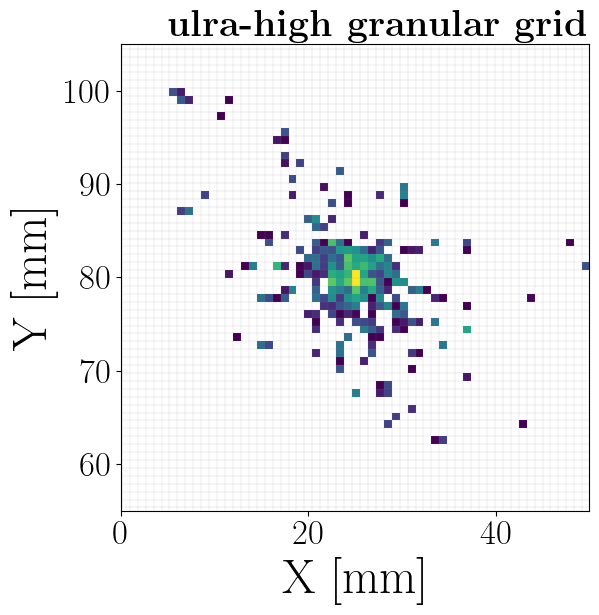

In [15]:
plt.figure(figsize=(7, 7))
X_mash, Z_mash = np.meshgrid(xedges_high, zedges_high)
# plt.pcolormesh(X_mash, Z_mash, np.log(H.T), cmap='gray')
# plt.pcolormesh(X_mash, Z_mash, H.T, cmap='viridis')
plt.pcolormesh(X_mash, Z_mash, np.log(H_high.T), cmap='viridis', vmax=-5.1, vmin=-9)


# plt.scatter(x, z, s=15, color='tab:blue')
for x_pos in xedges_high:
    plt.axvline(x_pos, color='gray', lw=0.1, zorder=1)
for z_pos in zedges_high:
    plt.axhline(z_pos, color='gray', lw=0.1, zorder=1)
# plt.pcolormesh(X_mash_base, Z_mash_base, np.log(H_base.T), cmap='gray')
plt.ylabel('Y [mm]')
plt.xlabel('X [mm]')
plt.title(r'\textbf{ulra-high granular grid}', loc='right', fontsize=27)
plt.ylim(80-25, 80+25)
plt.xlim(0, 50)
plt.tight_layout()
plt.savefig('high_granular_grid.png', dpi=300)
plt.show()

In [16]:
l = 20

In [17]:
# offset = cell_size/2 # for x4 grid
offset = cell_size/6 # for x36 grid
xedges_high = np.arange(-100, 100, offset)
zedges_high = np.arange(-60, 140, offset)




projections_high = []
projections_real = []
projections_high_to_real = []

for n in range(len(all_steps)):
    x = all_steps[n, 0][(all_steps[n, 1] > layer_bottom_pos[l]) & (all_steps[n, 1] < layer_bottom_pos[l] + cell_thickness)]
    z = all_steps[n, 2][(all_steps[n, 1] > layer_bottom_pos[l]) & (all_steps[n, 1] < layer_bottom_pos[l] + cell_thickness)]
    e = all_steps[n, 3][(all_steps[n, 1] > layer_bottom_pos[l]) & (all_steps[n, 1] < layer_bottom_pos[l] + cell_thickness)]
    
    
    H_high, xedges_high, zedges_high = np.histogram2d(x, z, bins=(xedges_high, zedges_high), weights=e)
    projections_high.append([H_high])
    
    H, xedges, zedges = np.histogram2d(x, z, bins=(xedges, zedges), weights=e)
    projections_real.append([H])
    
    
    
    x_high_bin, z_high_bin = np.where(H_high > 0)
    x_high, z_high, e_high = xedges_high[x_high_bin], zedges_high[z_high_bin], H_high[np.where(H_high > 0)]
    
    pos_offset_x = np.random.uniform(0, offset, 1)
    pos_offset_z = np.random.uniform(0, offset, 1)
    xedges_high = np.arange(-100+pos_offset_x, 100+pos_offset_z, offset)
    zedges_high = np.arange(-60+pos_offset_x, 140+pos_offset_z, offset)
    
    
    H_high_to_real, _, _ = np.histogram2d(x_high + offset/2, z_high + offset/2, bins=(xedges, zedges), weights=e_high)
    projections_high_to_real.append([H_high_to_real])

In [18]:
projections_real = np.vstack(projections_real)

projections_high_to_real = np.vstack(projections_high_to_real)

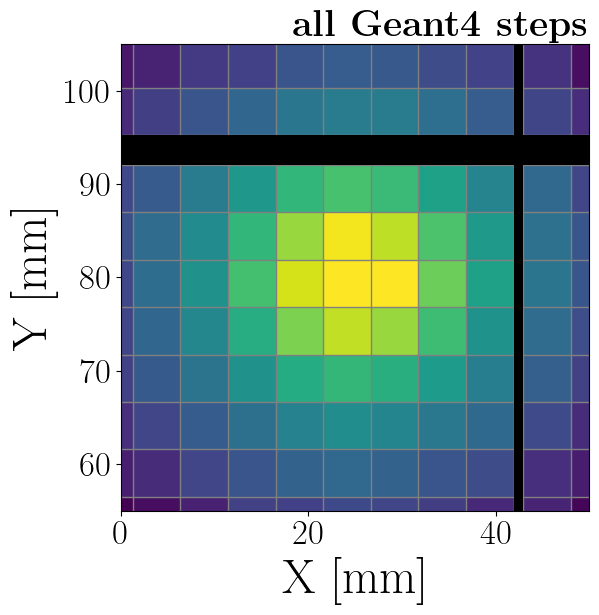

In [19]:
plt.figure(figsize=(7, 7))
X_mash, Z_mash = np.meshgrid(xedges, zedges)
# plt.pcolormesh(X_mash, Z_mash, np.log(H.T), cmap='gray')
# plt.pcolormesh(X_mash, Z_mash, H.T, cmap='viridis')
plt.pcolormesh(X_mash, Z_mash, np.log(projections_real.sum(axis=0)).T, cmap='viridis', vmax=2.5, vmin=-3)


for x_pos in xedges:
    plt.axvline(x_pos, color='gray', lw=1, zorder=1)
for z_pos in zedges:
    plt.axhline(z_pos, color='gray', lw=1, zorder=1)
plt.pcolormesh(X_mash_base, Z_mash_base, np.log(H_base.T), cmap='gray')
plt.ylabel('Y [mm]')
plt.xlabel('X [mm]')
plt.title(r'\textbf{all Geant4 steps}', loc='right', fontsize=27)
plt.ylim(80-25, 80+25)
plt.xlim(0, 50)
plt.tight_layout()
plt.savefig('grid_base_overlay.pdf', dpi=300)
plt.show()

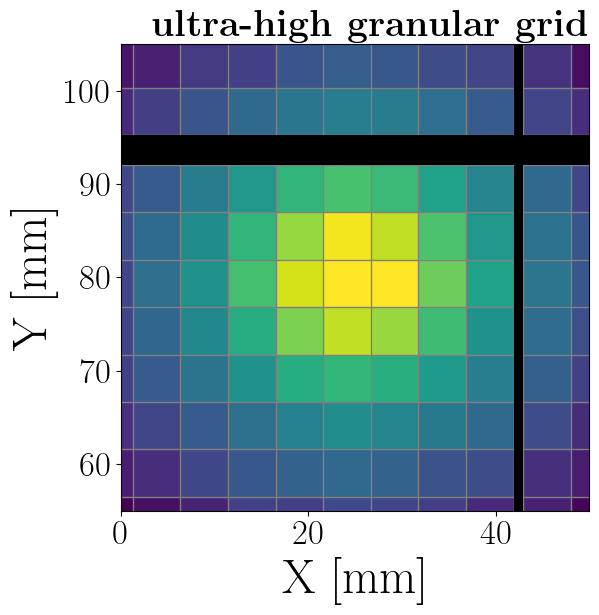

In [20]:
plt.figure(figsize=(7, 7))
X_mash, Z_mash = np.meshgrid(xedges, zedges)
# plt.pcolormesh(X_mash, Z_mash, np.log(H.T), cmap='gray')
# plt.pcolormesh(X_mash, Z_mash, H.T, cmap='viridis')
plt.pcolormesh(X_mash, Z_mash, np.log(projections_high_to_real.sum(axis=0)).T, cmap='viridis', vmax=2.5, vmin=-3)


for x_pos in xedges:
    plt.axvline(x_pos, color='gray', lw=1, zorder=1)
for z_pos in zedges:
    plt.axhline(z_pos, color='gray', lw=1, zorder=1)
plt.pcolormesh(X_mash_base, Z_mash_base, np.log(H_base.T), cmap='gray')
plt.ylabel('Y [mm]')
plt.xlabel('X [mm]')
plt.title(r'\textbf{ultra-high granular grid}', loc='right', fontsize=27)
plt.ylim(80-25, 80+25)
plt.xlim(0, 50)
plt.tight_layout()
plt.savefig('grid_base_overlay_high.pdf', dpi=300)
plt.show()

In [21]:
a = projections_real.sum(axis=0)
b = projections_high_to_real.sum(axis=0)

abs_relative_diff = abs((b-a)/a).T

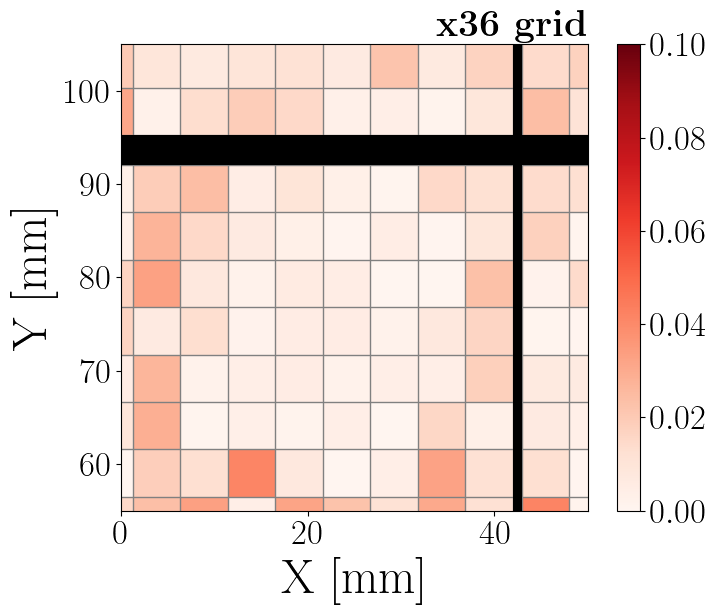

In [22]:
plt.figure(figsize=(8,  7))
X_mash, Z_mash = np.meshgrid(xedges, zedges)
# plt.pcolormesh(X_mash, Z_mash, np.log(H.T), cmap='gray')
# plt.pcolormesh(X_mash, Z_mash, H.T, cmap='viridis')
plt.pcolormesh(X_mash, Z_mash, abs_relative_diff, cmap='Reds', vmax=0.1, vmin=0)
plt.colorbar()

for x_pos in xedges:
    plt.axvline(x_pos, color='gray', lw=1, zorder=1)
for z_pos in zedges:
    plt.axhline(z_pos, color='gray', lw=1, zorder=1)
plt.pcolormesh(X_mash_base, Z_mash_base, np.log(H_base.T), cmap='gray')
plt.ylabel('Y [mm]')
plt.xlabel('X [mm]')
plt.title(r'\textbf{x36 grid}', loc='right', fontsize=27)
# plt.title(r'\textbf{abs. relative difference}', loc='right', fontsize=27)
plt.ylim(80-25, 80+25)
plt.xlim(0, 50)
plt.tight_layout()
plt.savefig('grid_base_overlay_diff_x36.pdf', dpi=300)

plt.show()